https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Statistical Programming with Python: Bike Sharing Prediction
## Group Assignment
By Team O2-2 (B)  
eddited by Duarte for Advanced Python Individual Assignment

### 1. Exploratory Data Analysis (descriptive analytics)

In [91]:
#Import libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#import missingno as msno
from sklearn.metrics import r2_score
from sklearn import metrics

import dask.dataframe as dd


from dask_ml.linear_model import LinearRegression
from dask_ml.xgboost import XGBRegressor

import dask_xgboost
import xgboost

from sklearn.ensemble import RandomForestRegressor

from dask_ml.preprocessing import Categorizer, DummyEncoder

### Load dataset

In [92]:
# Read the data
ddf_org = dd.read_csv(
    'https://s3.eu-west-2.amazonaws.com/adv-py-assignment/hour.csv'
)

### Data prep

We will try to predict the count value as it is the sum of the casual and registered. This means we have to leave these values out for the modelling.

In [93]:
# Predict cnt so casual and registered can be left out
ddf = ddf_org.drop(["casual", "registered"], axis=1)

As seen in the outlier detection, there where some outliers located in the numerical variables. We therefore tested our predictions with removing outliers outside three standard deviations from the mean of each variable. This process yielded the highest results when removing outliers only for "humidity"

In [94]:
# Eliminate the outliers detected using the boxplot.
#hour_no = hour_df[
    #np.abs(hour_df["windspeed"] - hour_df["windspeed"].mean()) <= (3 * hour_df["windspeed"].std())
#]

#hour_no = hour_no[
    #np.abs(hour_no["temp"] - hour_no["temp"].mean()) <= (3 * hour_no["temp"].std())
#]

ddf = ddf[
    np.abs(ddf["hum"] - ddf["hum"].mean()) <= (3 * ddf["hum"].std())
]

#### Data visualization

Now that we ensured the data quality regarding outliers and msising values; the next step is to look for correlations between different variables in the dataset using a correlation matrix. There is an almost 1 to 1 relationship between temp and atemp which means we will leave one of them out for our modelling. In this case temp has the biggest effect on the count value so we leave out atemp.

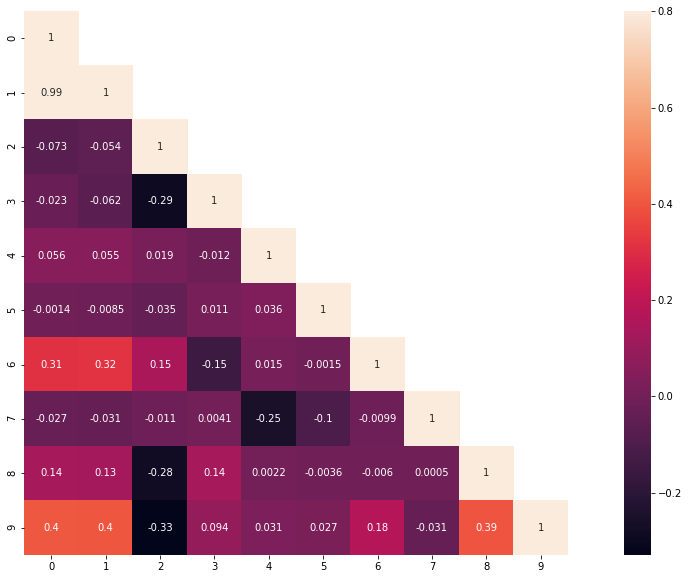

In [95]:
# Check the correlations of the different variables.
corrMatt = ddf[
    [
        "temp",
        "atemp",
        "hum",
        "windspeed",
        "workingday",
        "weekday",
        "season",
        "holiday",
        "hr",
        "cnt",
    ]
].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrMatt, mask=mask, vmax=0.8, square=True, annot=True)

In [96]:
# Remove temp because of the almost 1 to 1 correlation with atemp.
ddf = ddf.drop(["atemp"], axis=1)

Visualizing the data will show important insights for the modelling phase.
First of all we will take a look at the variables that showed the highest correlation with the cnt values in the correlation matrix: temp and hum. Showing a clearly linear relation between these two variable and the count variable.

Looking at the distribution of the rentals on a daily basis there are clearly periods of higher demand during a day, ie the moments people have to get home from/ go to work/school, and the other moments of the day.
Of course there is a big seasonal effect as well as an effect of wheteher it is a working day or not.

### Onehotencoding

Converting every type into categories in order to facilitate the dummy creation

In [116]:
cat = Categorizer()
ddf = cat.fit_transform(ddf)

In [117]:
# ddf.dtypes
# ddf1.dtypes

In [118]:
dum = DummyEncoder()
ddf = dum.fit_transform(ddf)

### 2. Machine Learning (predictive analytics)

In [75]:
ddf[ddf["dteday"] == "2012-10-01"].head(1)
train = ddf[ddf["instant"]<15212]
test = ddf[ddf["instant"]>=15212]

In [76]:
train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1


In [77]:
x_train = train.drop(['instant', 'cnt', 'dteday'], axis=1).to_dask_array()
y_train = train['cnt'].to_dask_array()

x_test = test.drop(['instant', 'cnt', 'dteday'], axis=1).to_dask_array()
y_test = test['cnt'].to_dask_array()

### 2.1 Linear regression
#### With dask ml models

Now we build the most basic model with Linear Regression

In [78]:
dask_lr = LinearRegression()
dask_lr.fit(x_train, y_train)

LinearRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
         intercept_scaling=1.0, max_iter=100, multi_class='ovr', n_jobs=1,
         penalty='l2', random_state=None, solver='admm',
         solver_kwargs=None, tol=0.0001, verbose=0, warm_start=False)

In [79]:
y_lr = dask_lr.predict(x_test)

In [80]:
r2_score(y_pred=y_lr.compute(), y_true=y_test.compute())

0.29032761930478557

We see from the R squared and MSE that the result is not good. We will encode our categorical variables to find a better result

### 2.2 Random forest

#### With dask API for sklearn

In [81]:
from joblib import Parallel, parallel_backend

In [82]:
with parallel_backend("dask"):
    rf_model = RandomForestRegressor(n_estimators=200)
    rf_model.fit(x_train, y_train)
    y_rf = rf_model.predict(x_test)

In [83]:
r2_score(y_pred=y_rf, y_true=y_test.compute())

0.8730796042884048

### 2.3 XBoost
#### With dask ml models and needing client configuration

In [84]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=1)

/usr/local/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [85]:
params = {"max_depth": 5, "alpha": 10, "n_estimators": 5000, "colsample_bytree": 0.3}

dask_xgboost.train(
    client=client, data=x_train, labels=y_train, num_boost_round=10, params=params
)

In [86]:
y_xgb = dask_xgboost.predict(client, xgb_model, x_test).persist()

In [87]:
r2_score(y_pred=y_xgb.compute(), y_true=y_test.compute())

0.46723107968085353

#### Random forest - Grid search

O/S

#### Model pipeline